In [ ]:
!pip install astroquery galpy astropy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from astroquery.gaia import Gaia
import astropy.units as u
import astropy.constants
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord, Galactocentric, CylindricalRepresentation, Distance
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit

In [3]:
job = Gaia.launch_job_async('SELECT TOP 10 source_id, dr2_radial_velocity, dr2_radial_velocity_error, '+
                            'ra, ra_error, dec, dec_error, parallax, parallax_error, l, b, '+
                            'pmra, pmra_error, pmdec, pmdec_error, '+
                            'ra_dec_corr, ra_parallax_corr, ra_pmra_corr, ra_pmdec_corr, '+
                            'dec_parallax_corr, dec_pmra_corr, dec_pmdec_corr, '+
                            'parallax_pmra_corr, parallax_pmdec_corr, pmra_pmdec_corr '+
                            'FROM gaiaedr3.gaia_source '+
                            'WHERE parallax_over_error > 10. '+
                            'AND dr2_radial_velocity IS NOT NULL '+
                            'AND dr2_radial_velocity_error < 5'
                           )
                           
table = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


# 座標変換等

In [4]:
table['distance'] = Distance(parallax=table['parallax'].data*u.mas)
skycoords=SkyCoord(ra=table['ra'].data*u.deg,
                   dec=table['dec'].data*u.deg,
                   pm_ra_cosdec=table['pmra'].data*u.mas/u.yr,
                   pm_dec=table['pmdec'].data*u.mas/u.yr,
                   radial_velocity=table['dr2_radial_velocity'].data*u.km/u.s,
                   distance=table['distance'].data*u.pc,
                  )

# 軌道計算
軸対称な天の川銀河重力ポテンシャルモデル (MWPotential2014)を仮定して軌道計算

In [5]:
orbits = [Orbit(s) for s in skycoords]
times = np.linspace(0.,1.,500)*u.Gyr
for o in orbits:
    o.integrate(times, MWPotential2014)

# 可視化
## 2D/3Dで軌道をプロット

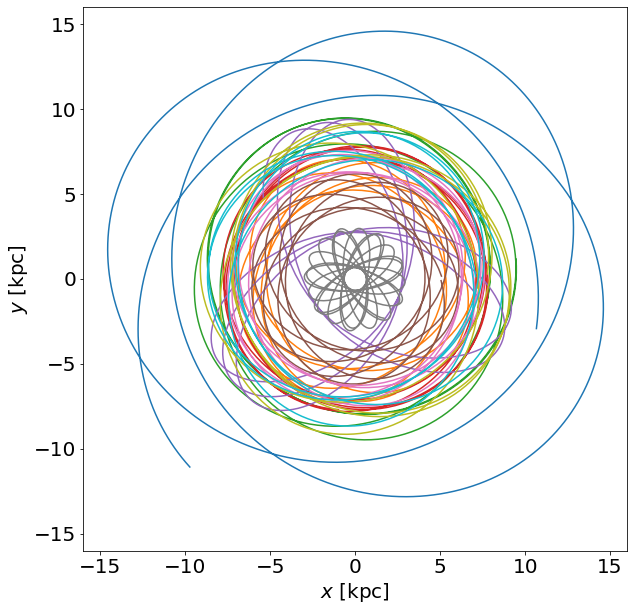

In [6]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.set_aspect(1)
for o in orbits:
    ax.plot(o.x(times), o.y(times))
ax.set_xlim(-16, 16)
ax.set_ylim(-16, 16)
ax.set_xlabel(f'$x$ [kpc]', fontsize=20)
ax.set_ylabel(f'$y$ [kpc]', fontsize=20)
ax.tick_params(labelsize=20)

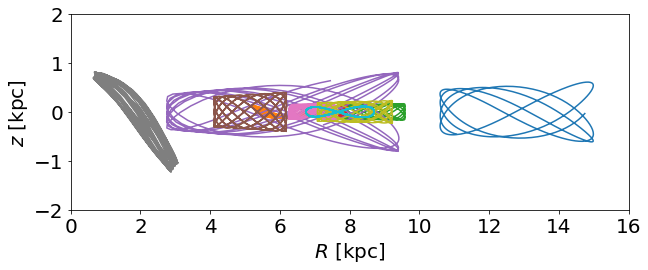

In [7]:
fig = plt.figure(figsize=[10, 4])
fig.subplots_adjust(bottom=0.2)
ax = fig.add_subplot(111)
for o in orbits:
    ax.plot(o.R(times), o.z(times))
ax.set_xlim(0, 16)
ax.set_ylim(-2, 2)
ax.set_xlabel(f'$R$ [kpc]', fontsize=20)
ax.set_ylabel(f'$z$ [kpc]', fontsize=20)
ax.tick_params(labelsize=20)

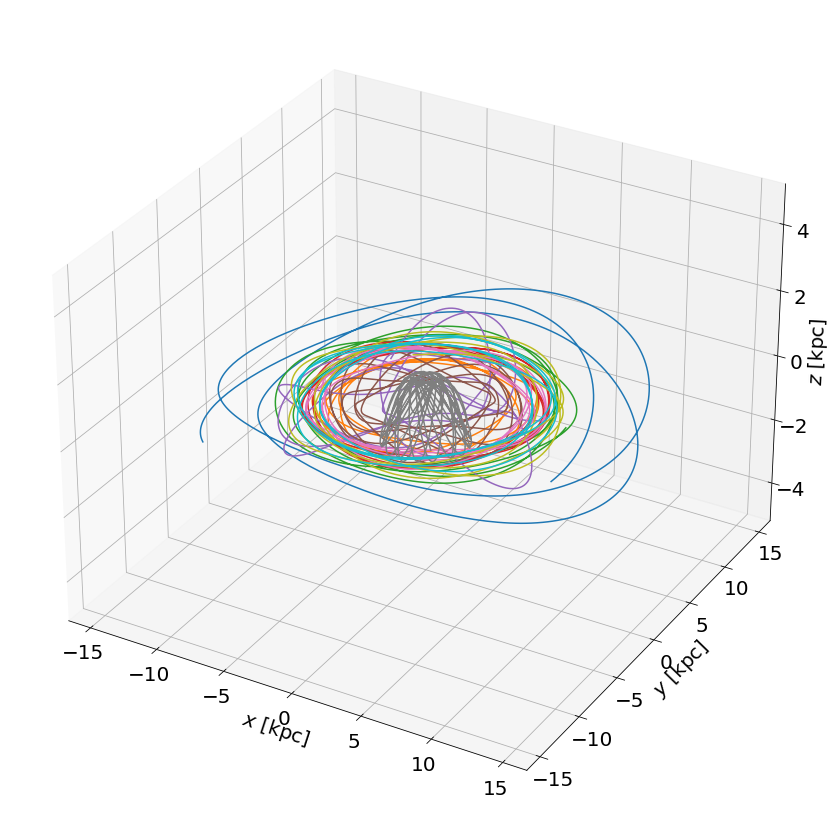

In [8]:
fig = plt.figure(figsize=[15, 15])
ax = fig.add_subplot(111, projection='3d')
for o in orbits:
    ax.plot(o.x(times), o.y(times), o.z(times))
ax.set_xlim(-16, 16)
ax.set_ylim(-16, 16)
ax.set_zlim(-5, 5)
ax.set_xlabel(f'$x$ [kpc]', fontsize=20)
ax.set_ylabel(f'$y$ [kpc]', fontsize=20)
ax.set_zlabel(f'$z$ [kpc]', fontsize=20)
ax.tick_params(labelsize=20)

## アニメーション

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')

In [ ]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)

def update_frame(n):
    ax.cla()
    ax.set_aspect(1)
    for o in orbits:
        ax.plot(o.x(times[:n]), o.y(times[:n]))
    ax.set_xlim(-16, 16)
    ax.set_ylim(-16, 16)
    ax.set_xlabel(f'$x$ [kpc]', fontsize=20)
    ax.set_ylabel(f'$y$ [kpc]', fontsize=20)
    ax.text(-15, -15, f'$t={times.value[n]:.3f}$ Gyr', fontsize=20)
    ax.tick_params(labelsize=20)
anim = FuncAnimation(fig, update_frame, frames=np.arange(0, len(times)), interval=50)
anim
#anim.save("2dorbits_xy.mp4", writer="ffmpeg", dpi=200) 

In [ ]:
fig = plt.figure(figsize=[10, 4])
fig.subplots_adjust(bottom=0.2)
ax = fig.add_subplot(111)

def update_frame(n):
    ax.cla()
    for o in orbits:
        ax.plot(o.R(times[:n]), o.z(times[:n]))
    ax.set_xlim(0, 16)
    ax.set_ylim(-2, 2)
    ax.set_xlabel(f'$R$ [kpc]', fontsize=20)
    ax.set_ylabel(f'$z$ [kpc]', fontsize=20)
    ax.text(1, -1.8, f'$t={times.value[n]:.3f}$ Gyr', fontsize=20)
    ax.tick_params(labelsize=20)
anim = FuncAnimation(fig, update_frame, frames=np.arange(0, len(times)), interval=50)
anim
#anim.save("2dorbits_Rz.mp4", writer="ffmpeg", dpi=200) 

In [ ]:
fig = plt.figure(figsize=[15.,15.])
ax = fig.add_subplot(111, projection='3d')

def update_frame(n):
    ax.cla()
    for o in orbits:
        ax.plot(o.x(times[:n]), o.y(times[:n]), o.z(times[:n]))
    ax.set_xlim(-16, 16)
    ax.set_ylim(-16, 16)
    ax.set_zlim(-5, 5)
    ax.set_xlabel(f'$x$ [kpc]', fontsize=20)
    ax.set_ylabel(f'$y$ [kpc]', fontsize=20)
    ax.set_zlabel(f'$z$ [kpc]', fontsize=20)
    ax.text(-15, -10, 4, f'$t={times.value[n]:.3f}$ Gyr', fontsize=20)
    ax.tick_params(labelsize=20)
anim = FuncAnimation(fig, update_frame, frames=np.arange(0, len(times)), interval=50)
anim
#anim.save("3dorbits.mp4", writer="ffmpeg", dpi=200) 